In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

<hr>

Define dataset path

In [2]:
folder = os.path.join("..", "data")
filename = "hotel_bookings.csv"

filepath = os.path.join(folder, filename)

<hr>

Load dataset

In [3]:
df = pd.read_csv(filepath)

<hr> 

Check dtypes and non-nulls for each column

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

<hr>

Create a column to keep date as YYYY-MM-DD

In [5]:
df["arrival_date_month_number"] = df["arrival_date_month"].map(lambda x: datetime.strptime(x, "%B").month)


df["arrival_date"] = pd.to_datetime(df.rename(columns={"arrival_date_year": "Year", 
                                                       "arrival_date_month_number": "Month",
                                                       "arrival_date_day_of_month": "Day"})[["Day", "Month", "Year"]])

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_number,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,2015-07-01


<hr>

Group data by hotel and arrival_date, counting the number of bookings and cancellations

In [6]:
df_group_date = df.groupby(["hotel", "arrival_date"]).agg({"arrival_date": "count",
                                                           "is_canceled": "sum"})
df_group_date = df_group_date.rename(columns={"arrival_date": "total_bookings",
                                              "is_canceled": "total_canceled"})

<hr>

Create a new column called cancel_rate

In [7]:
df_group_date["cancel_rate"] = df_group_date["total_canceled"]/df_group_date["total_bookings"]

df_group_date.sample(10).sort_index()

total_bookings  total_canceled  cancel_rate
hotel        arrival_date                                             
City Hotel   2015-07-18               111              68     0.612613
             2015-10-17               121              67     0.553719
             2016-01-17                25               4     0.160000
             2016-02-02                30              15     0.500000
Resort Hotel 2015-08-19                27               7     0.259259
             2015-09-27                31               5     0.161290
             2015-10-21                70              16     0.228571
             2016-07-02                54              18     0.333333
             2016-09-09                49              10     0.204082
             2016-12-05                59              11     0.186441

<hr>

Plot data for each Hotel, such as cancel rate timeseries, cancel rate trend timeseries, cancel rate seasonality timeseries, average cancel rate per day and average cancel rate per month

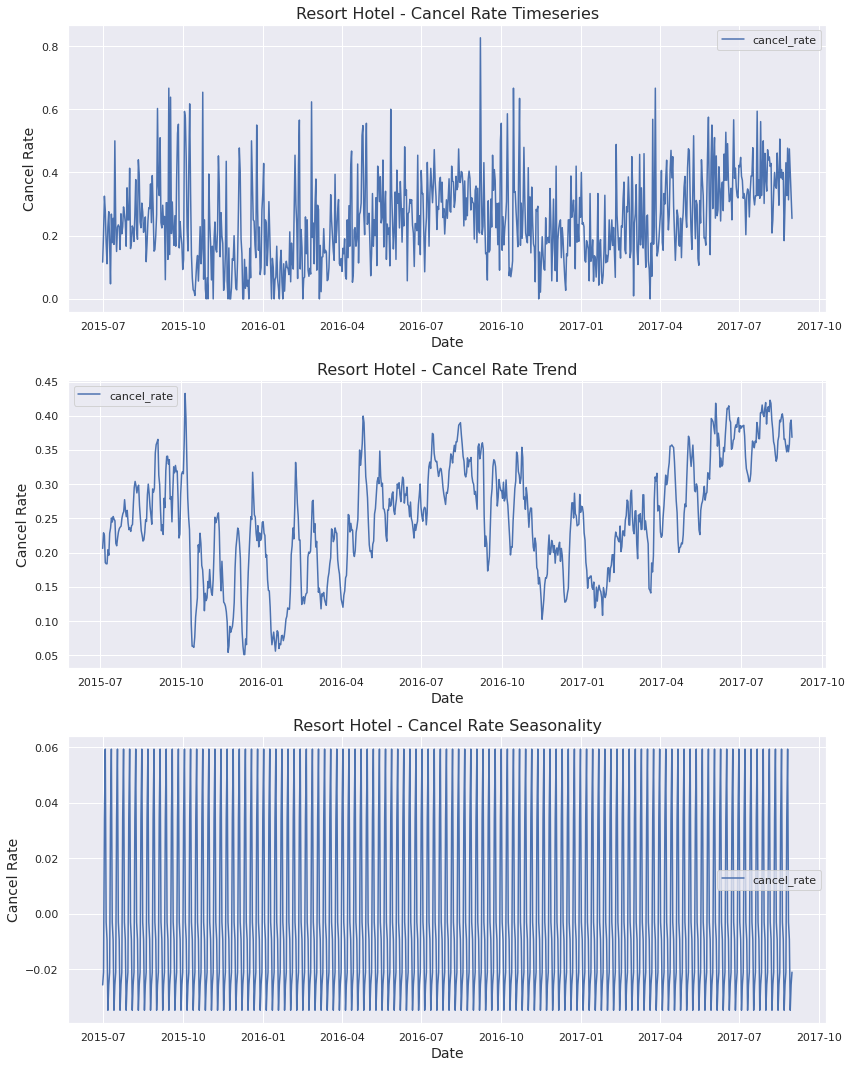

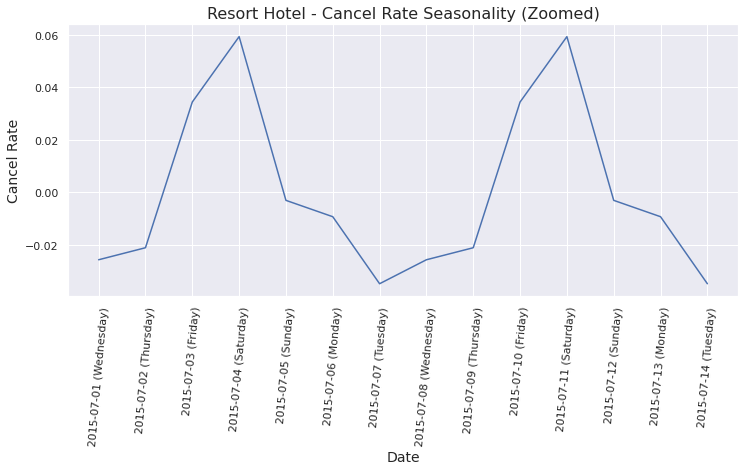

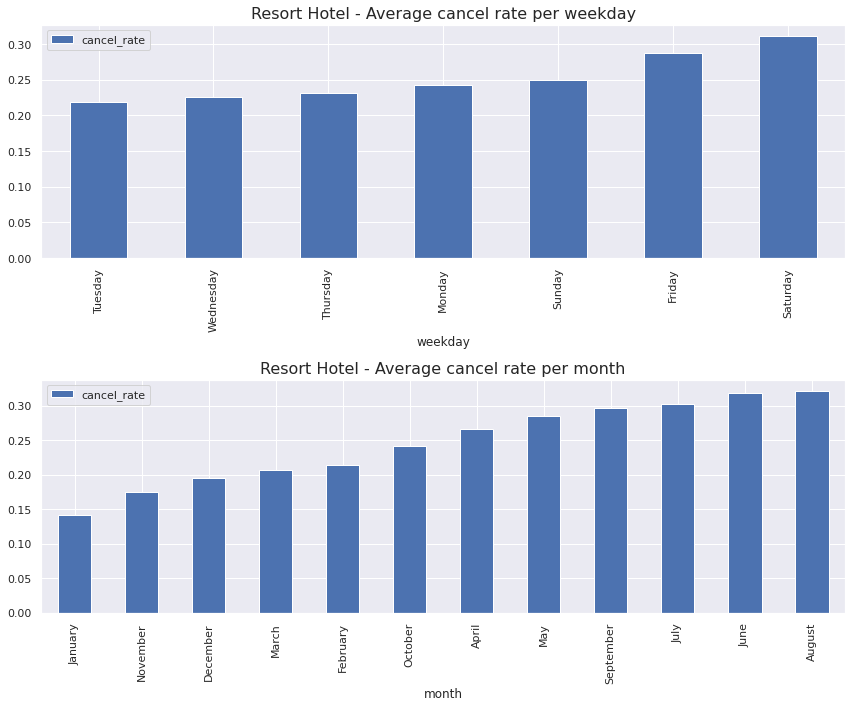

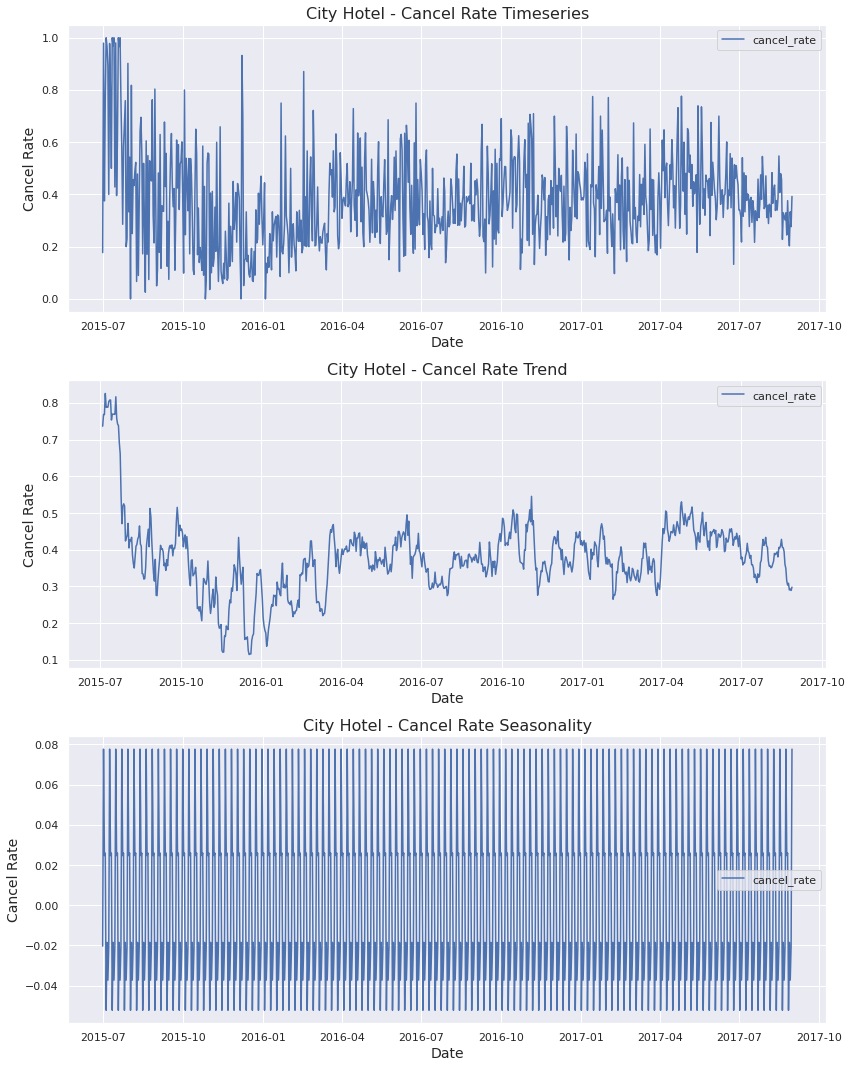

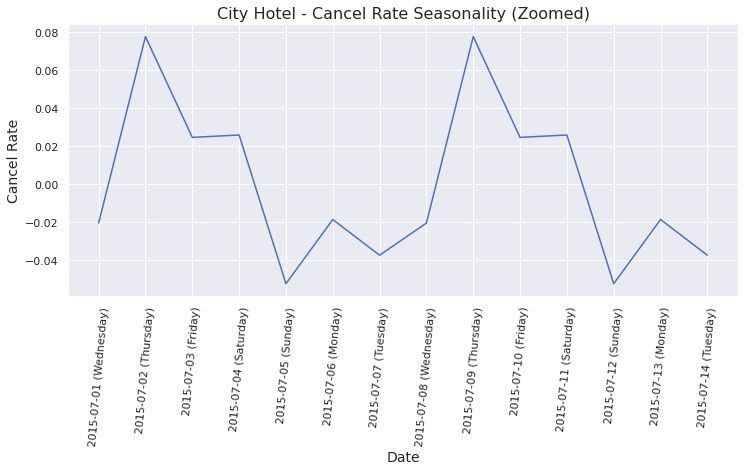

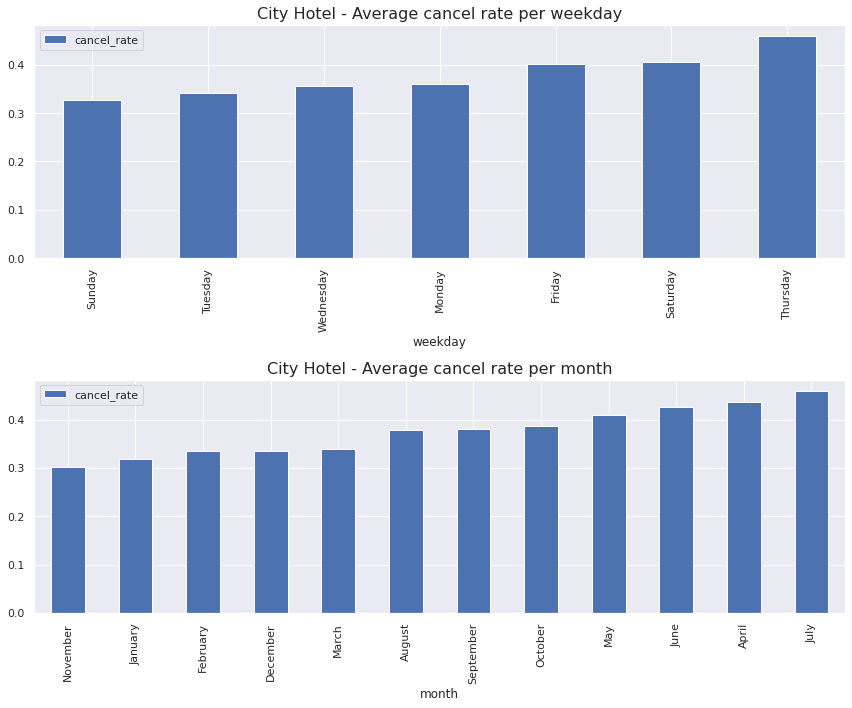

In [8]:
for hotel in df["hotel"].unique():
    df_hotel = df_group_date.loc[hotel]
    sd = seasonal_decompose(df_hotel["cancel_rate"])
    df_hotel["trend"] = sd.trend.values
    df_hotel["seasonal"] = sd.seasonal.values
    
    fig, ax = plt.subplots(nrows=3, figsize=(12, 15))
    
    ax[0].set_title(f"{hotel} - Cancel Rate Timeseries", fontsize=16)
    ax[0].set_ylabel("Cancel Rate", fontsize=14)
    ax[0].set_xlabel("Date", fontsize=14)
    ax[0].plot(df_hotel["cancel_rate"])
    ax[0].legend(["cancel_rate"])
    
    
    ax[1].set_title(f"{hotel} - Cancel Rate Trend", fontsize=16)
    ax[1].set_ylabel("Cancel Rate", fontsize=14)
    ax[1].set_xlabel("Date", fontsize=14)
    ax[1].plot(df_hotel["trend"])
    ax[1].legend(["cancel_rate"])
    
    
    ax[2].set_title(f"{hotel} - Cancel Rate Seasonality", fontsize=16)
    ax[2].set_ylabel("Cancel Rate", fontsize=14)
    ax[2].set_xlabel("Date", fontsize=14)
    ax[2].plot(df_hotel["seasonal"])
    ax[2].legend(["cancel_rate"])
    
    plt.tight_layout()
    
    df_hotel["date_weekday_str"] = df_hotel.index.map(lambda x: f"{x.strftime('%Y-%m-%d')} ({x.strftime('%A')})")
    
    fig, ax = plt.subplots(nrows=1, figsize=(12, 5))
    ax.set_title(f"{hotel} - Cancel Rate Seasonality (Zoomed)", fontsize=16)
    ax.set_ylabel("Cancel Rate", fontsize=14)
    ax.set_xlabel("Date", fontsize=14)
    ax.plot(df_hotel["date_weekday_str"][:14], df_hotel["seasonal"][:14])
    for label in ax.get_xticklabels():
        label.set_rotation(85)
    plt.show()
    ax.legend(["cancel_rate"])
    
    
    df_hotel["weekday"] = df_hotel.index.map(lambda x: f"{x.strftime('%A')}")
    df_hotel["month"] = df_hotel.index.map(lambda x: f"{x.strftime('%B')}")
    
    
    fig, ax = plt.subplots(nrows=2, figsize=(12, 10))
    df_hotel.groupby("weekday").agg({"cancel_rate": "mean"}).sort_values(by="cancel_rate").plot.bar(ax=ax[0])
    ax[0].set_title(f"{hotel} - Average cancel rate per weekday", fontsize=16)
    df_hotel.groupby("month").agg({"cancel_rate": "mean"}).sort_values(by="cancel_rate").plot.bar(ax=ax[1])
    ax[1].set_title(f"{hotel} - Average cancel rate per month", fontsize=16)
    plt.tight_layout()
    
    print("\n\n")

<hr>

Get correlations to find promising features

In [9]:
df.corr().iloc[:, 0]

is_canceled                       1.000000
lead_time                         0.293123
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001791
stays_in_week_nights              0.024765
adults                            0.060017
children                          0.005048
babies                           -0.032491
is_repeated_guest                -0.084793
previous_cancellations            0.110133
previous_bookings_not_canceled   -0.057358
booking_changes                  -0.144381
agent                            -0.083114
company                          -0.020642
days_in_waiting_list              0.054186
adr                               0.047557
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
arrival_date_month_number         0.011022
Name: is_canceled, dtype: float64

<hr>

Plot NA values and unique values per column

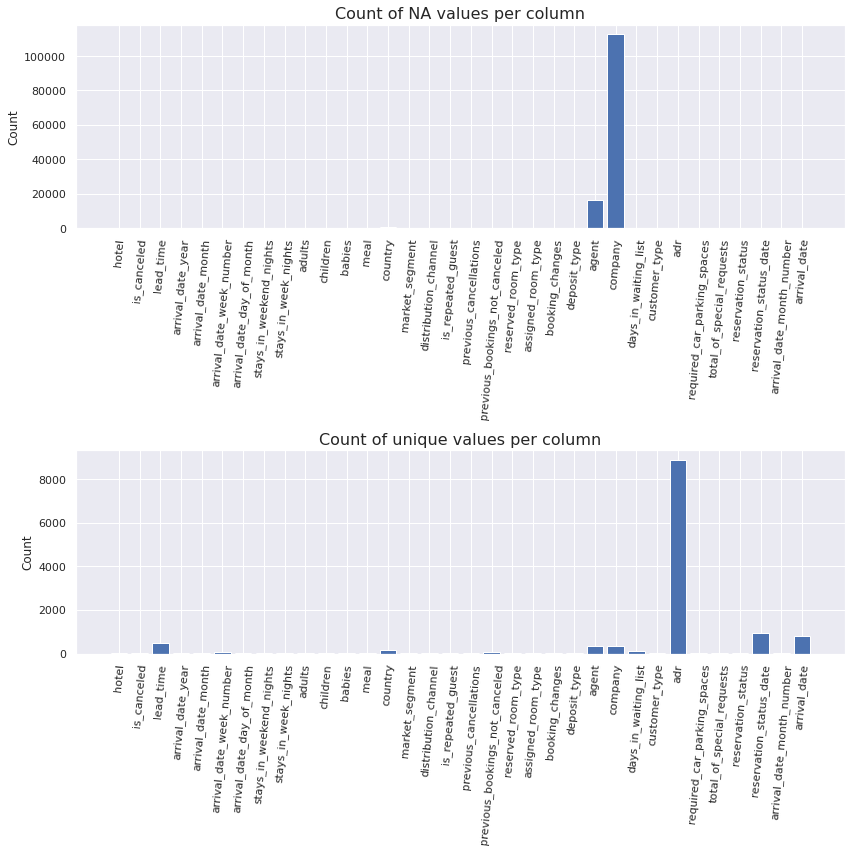

In [10]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 12))

ax[0].set_title("Count of NA values per column", fontsize=16)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].bar(df.isna().sum().index, df.isna().sum().values)
for label in ax[0].get_xticklabels():
    label.set_rotation(85)


ax[1].set_title("Count of unique values per column", fontsize=16)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].bar(df.nunique().index, df.nunique().values)
for label in ax[1].get_xticklabels():
    label.set_rotation(85)

plt.tight_layout()

<hr>

Create a dataframe merging dtypes, number of unique values, number of NA values of each column.<br>
It will make easier to find bad features.

In [11]:
df_types_unique_null = pd.concat([df.dtypes, df.nunique(), df.isna().sum()], axis=1)
df_types_unique_null = df_types_unique_null.rename(columns={0: "dtype", 1: "nunique", 2: "nna"})
df_types_unique_null

,dtype,nunique,nna
hotel,object,2,0
is_canceled,int64,2,0
lead_time,int64,479,0
arrival_date_year,int64,3,0
arrival_date_month,object,12,0
arrival_date_week_number,int64,53,0
arrival_date_day_of_month,int64,31,0
stays_in_weekend_nights,int64,17,0
stays_in_week_nights,int64,35,0
adults,int64,14,0


<hr>
Create a list of columns to drop, and inspect manually which columns to insert to this list.

In [12]:
columns_to_drop = []

In [13]:
df_types_unique_null[df_types_unique_null["dtype"] == "object"]

,dtype,nunique,nna
hotel,object,2,0
arrival_date_month,object,12,0
meal,object,5,0
country,object,177,488
market_segment,object,8,0
distribution_channel,object,5,0
reserved_room_type,object,10,0
assigned_room_type,object,12,0
deposit_type,object,3,0
customer_type,object,4,0


In [14]:
columns_to_drop.append("country") #Avoid bias; high cardinality
columns_to_drop.append("reservation_status_date") #High cardinality

In [15]:
df_types_unique_null[df_types_unique_null["nna"] > 0]

,dtype,nunique,nna
children,float64,5,4
country,object,177,488
agent,float64,333,16340
company,float64,352,112593


In [16]:
columns_to_drop.append("agent") #High number of NA
columns_to_drop.append("company") #High number of NA

In [17]:
df_types_unique_null[df_types_unique_null["nunique"] > 10]

,dtype,nunique,nna
lead_time,int64,479,0
arrival_date_month,object,12,0
arrival_date_week_number,int64,53,0
arrival_date_day_of_month,int64,31,0
stays_in_weekend_nights,int64,17,0
stays_in_week_nights,int64,35,0
adults,int64,14,0
country,object,177,488
previous_cancellations,int64,15,0
previous_bookings_not_canceled,int64,73,0


In [18]:
columns_to_drop.append("arrival_date_week_number") #Useless, it doesn't have a logical order
columns_to_drop.append("arrival_date_month_number") #Useless, it doesn't have a logical order
columns_to_drop.append("arrival_date_day_of_month") #Useless, it doesn't have a logical order
columns_to_drop.append("arrival_date_year") #Useless, it doesn't have a logical order

In [19]:
#Similar to is_canceled, but including 'No-Show'
display(df["reservation_status"].unique())
columns_to_drop.append("reservation_status")

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

<hr>

Feature Engineering: Create two new features: cancel_rate_costumer, arrival_date_weekday

In [20]:
#Cancel rate costumer
df["cancel_rate_costumer"] = df["previous_cancellations"]/(df["previous_cancellations"] + df["previous_bookings_not_canceled"])
df["cancel_rate_costumer"] = df["cancel_rate_costumer"].replace(np.nan, 0)
columns_to_drop.append("previous_cancellations") #Useless, since we created a new one
columns_to_drop.append("previous_bookings_not_canceled") #Useless, since we created a new one

#Arrival date weekday
df["arrival_date_weekday"] = df["arrival_date"].map(lambda x: x.strftime("%A"))
columns_to_drop.append("arrival_date")

<hr>

Drop selected columns from dataframe and display it

In [21]:
pd.set_option('display.max_columns', 25)

df = df.drop(columns_to_drop, axis=1)
df = df.dropna(axis=0).reset_index(drop=True)

print(f"df shape: {df.shape}")
display(df.sample(10))

df shape: (119386, 24)


,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,cancel_rate_costumer,arrival_date_weekday
53646,City Hotel,1,157,June,2,3,2,0.0,0,BB,Online TA,TA/TO,0,A,A,0,No Deposit,0,Transient,90.95,0,0,0.0,Sunday
35157,Resort Hotel,0,351,April,2,5,2,0.0,0,HB,Groups,TA/TO,0,D,D,0,No Deposit,0,Transient-Party,82.00,0,0,0.0,Saturday
32523,Resort Hotel,0,24,January,0,3,2,0.0,0,HB,Online TA,TA/TO,0,A,A,0,No Deposit,0,Transient,78.00,0,1,0.0,Thursday
90528,City Hotel,0,118,June,1,1,1,0.0,0,BB,Offline TA/TO,Corporate,0,A,A,1,No Deposit,0,Transient-Party,110.00,0,0,0.0,Monday
7114,Resort Hotel,1,34,July,0,2,2,0.0,0,HB,Online TA,TA/TO,0,A,A,0,No Deposit,0,Transient,211.00,0,0,0.0,Friday
88703,City Hotel,0,15,May,1,1,2,0.0,0,BB,Online TA,TA/TO,0,A,A,0,No Deposit,0,Transient,111.00,0,1,0.0,Monday
48452,City Hotel,1,36,March,2,4,2,0.0,0,BB,Online TA,TA/TO,0,D,D,0,No Deposit,0,Transient,125.10,0,2,0.0,Wednesday
93288,City Hotel,0,130,July,2,1,2,0.0,0,BB,Online TA,TA/TO,0,A,A,0,No Deposit,0,Transient,105.30,0,0,0.0,Sunday
6861,Resort Hotel,1,10,July,0,2,2,0.0,0,BB,Direct,Direct,0,E,E,0,No Deposit,0,Transient,199.00,0,1,0.0,Friday
41031,City Hotel,0,2,August,0,2,2,2.0,0,BB,Direct,Direct,0,D,D,0,No Deposit,0,Transient,15.00,0,2,0.0,Tuesday


<hr>

Summary statistics for the remaining dataframe

In [22]:
df.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,cancel_rate_costumer
count,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000
mean,0.370395,104.014801,0.927605,2.500310,1.856390,0.103890,0.007949,0.031913,0.221131,2.321227,101.833541,0.062520,0.571340,0.050182
std,0.482913,106.863286,0.998618,1.908289,0.579261,0.398561,0.097438,0.175770,0.652315,17.595011,50.534664,0.245295,0.792798,0.216516
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000,0.000000
50%,0.000000,69.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.590000,0.000000,0.000000,0.000000
75%,1.000000,160.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,1.000000


<hr>

Turn categorical variables into dummies, creating new columns with only 0s and 1s values.

In [23]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,...,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_date_weekday_Monday,arrival_date_weekday_Saturday,arrival_date_weekday_Sunday,arrival_date_weekday_Thursday,arrival_date_weekday_Tuesday,arrival_date_weekday_Wednesday
0,0,342,0,0,2,0.0,0,0,3,0,0.00,0,...,0,0,0,0,1,0,0,0,0,0,0,1
1,0,737,0,0,2,0.0,0,0,4,0,0.00,0,...,0,0,0,0,1,0,0,0,0,0,0,1
2,0,7,0,1,1,0.0,0,0,0,0,75.00,0,...,0,0,0,0,1,0,0,0,0,0,0,1
3,0,13,0,1,1,0.0,0,0,0,0,75.00,0,...,0,0,0,0,1,0,0,0,0,0,0,1
4,0,14,0,2,2,0.0,0,0,0,0,98.00,0,...,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119381,0,23,2,5,2,0.0,0,0,0,0,96.14,0,...,0,0,0,0,1,0,0,0,0,0,0,1
119382,0,102,2,5,3,0.0,0,0,0,0,225.43,0,...,0,0,0,0,1,0,0,0,0,1,0,0
119383,0,34,2,5,2,0.0,0,0,0,0,157.71,0,...,0,0,0,0,1,0,0,0,0,1,0,0
119384,0,109,2,5,2,0.0,0,0,0,0,104.40,0,...,0,0,0,0,1,0,0,0,0,1,0,0


<hr>

Perform feature importance, to check if there is an outstanding feature

In [24]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

In [25]:
X = df_dummies.drop("is_canceled", axis=1)
y = df_dummies["is_canceled"]

dtc.fit(X, y)

DecisionTreeClassifier()

<hr>

Plot feature importance for each feature

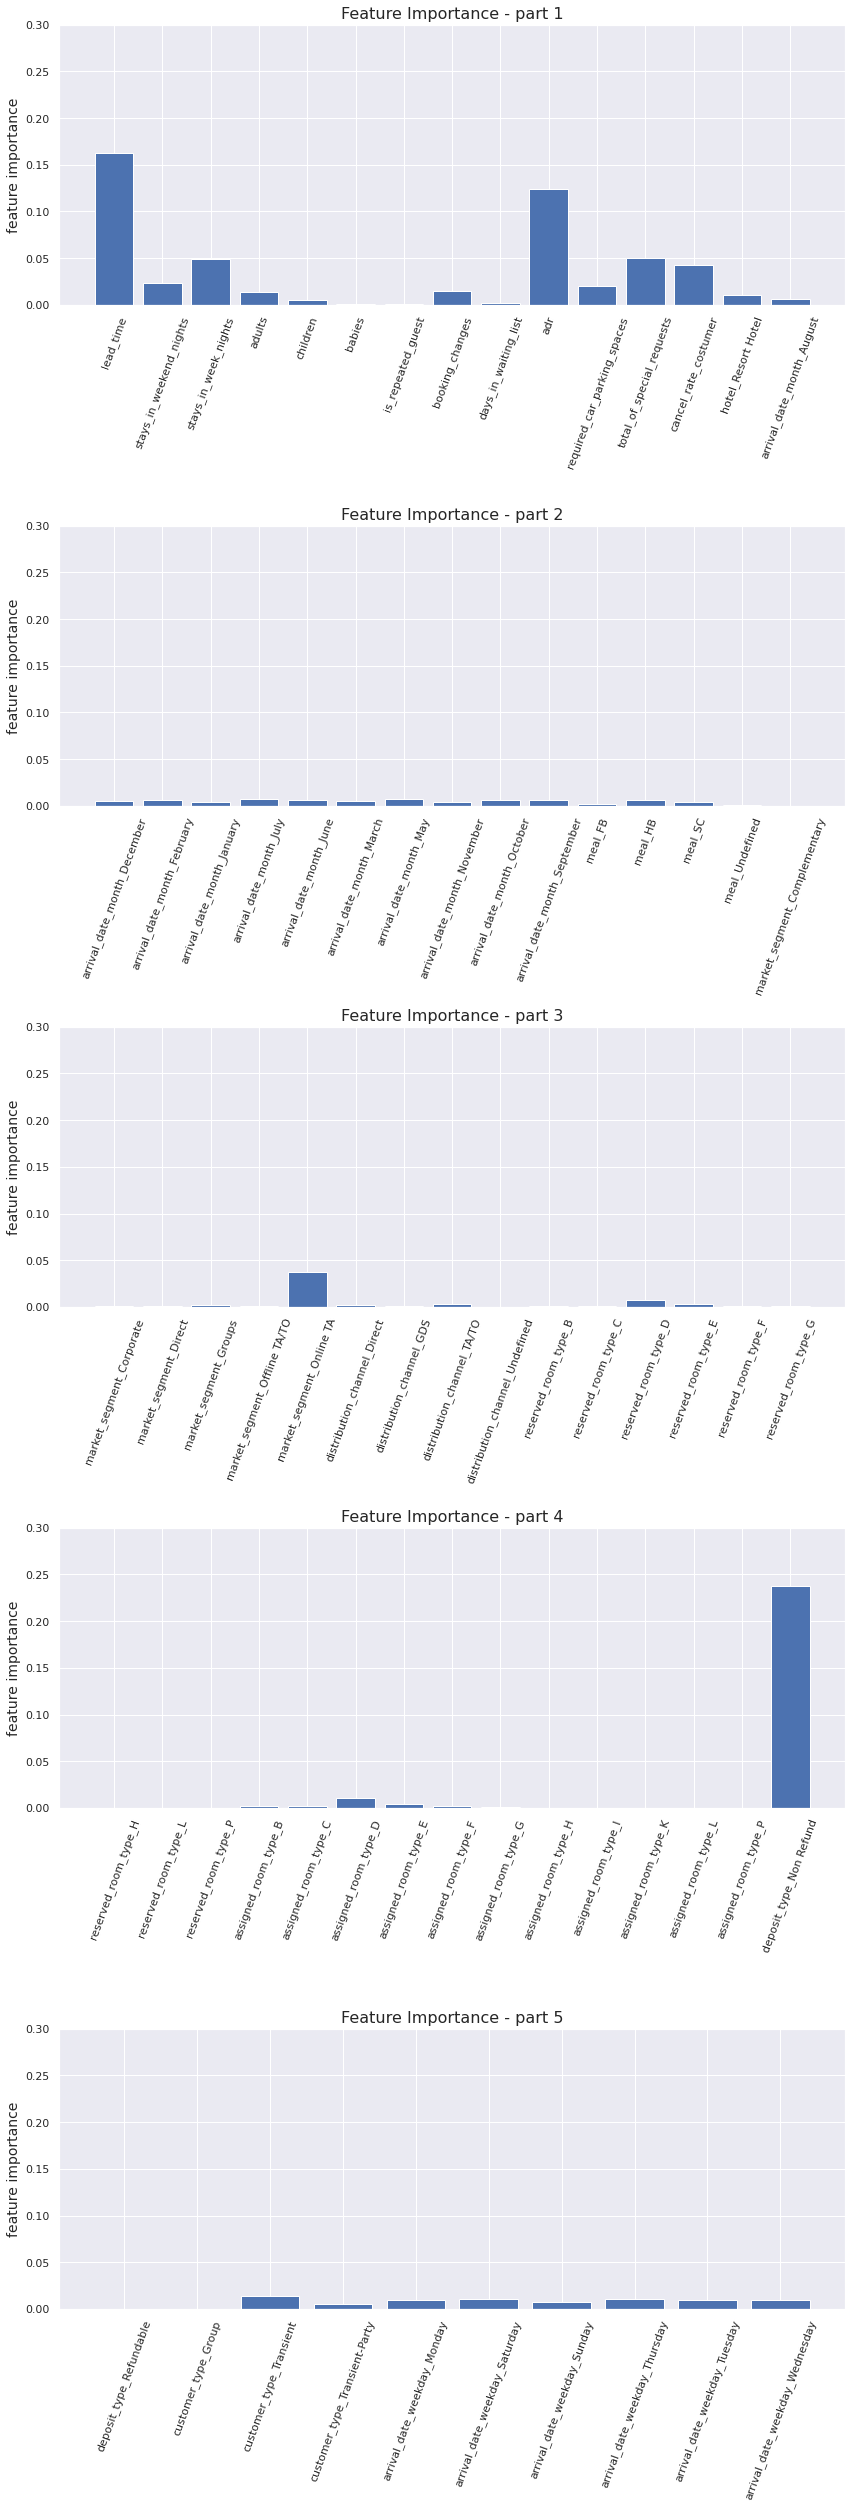

In [26]:
importance = dtc.feature_importances_

nrows = int(len(importance)/15 + 1)
fig, ax = plt.subplots(nrows=nrows, figsize=(12, 7*nrows))

for i in range(nrows):
    ax[i].set_title(f"Feature Importance - part {i+1}", fontsize=16)
    ax[i].set_ylabel("feature importance", fontsize=14)
    ax[i].bar(X.columns[i*15:(i+1)*15], importance[i*15:(i+1)*15])
    ax[i].set_ylim(0, 0.3)
    
    for label in ax[i].get_xticklabels():
        label.set_rotation(70)

plt.tight_layout()

<hr>

Save df_dummies

In [27]:
# Save DataFrame with dummies

folder = os.path.join("..", "data")
filename = "df_dummies.csv"
filepath = os.path.join(folder, filename)

df_dummies.to_csv(filepath, index=False)